# See .py file for updated code

In [2]:
from struct import unpack, pack, calcsize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import os
from collections import defaultdict
from datetime import datetime, timedelta
import traceback
import time
import cPickle as pickle

### Reads binary HR file

In [2]:
def read_HR_file(HR_file):
    full_data = []
    with open(HR_file, 'rb') as f:
        full = f.read()
        fmt = "16s8s8s4siiiiid"
        data_len = (len(full) - calcsize(fmt))/8

        fmt = fmt + str(data_len) + "d"
        full_data = unpack(fmt,full)
        measure_name, uom, ICU_unit, bed, year, month, day, hour, minute, second, data = full_data[0], \
                                                                        full_data[1], \
                                                                        full_data[2],\
                                                                        full_data[3],\
                                                                        full_data[4],\
                                                                        full_data[5],\
                                                                        full_data[6],\
                                                                        full_data[7],\
                                                                        full_data[8],\
                                                                        full_data[9],\
                                                                        full_data[10:]
    f.close()
    
    data = np.reshape(list(data), (4, len(data)/4), order = 'F')
    data_df = pd.DataFrame(data).transpose()
    
    #Create date
    date_str = str(month).zfill(2) + str(day).zfill(2) \
            + str(year).zfill(2) + " " + str(hour).zfill(2) \
            + str(minute).zfill(2) + str(int(second)).zfill(2)
    date_format = '%m%d%Y %H%M%S'
    try:
        date = datetime.strptime(date_str, date_format)
    except:
        date = None

    #delete full data after it has been unpacked
    del full_data   

    #Removes any values outside HR bounds of 10 and 300 
    data_df = data_df[(data_df.iloc[:,0] > 10) & (data_df.iloc[:,0] < 300)]
    
    return date, ICU_unit, data_df 

### Combine HR files that are in same folder (and therefore same ICU stay)

In [3]:
def combine_HR_files(HR_files, using_files = True, old = {}, new_df = {}, new_date = 0):
    if using_files:
        HR_files = sorted(HR_files, key = lambda x: int(x.split('_')[-2]))
        date = 0
        ICU_unit = ''
        final_df = pd.DataFrame()
        for f in HR_files: 
            if final_df.empty:
                date, ICU_unit, final_df = read_HR_file(f)
                if not final_df.empty:
                    time_last_entry = final_df.iloc[-1,1]
            else:
                date_temp, ICU_unit, cur_df = read_HR_file(f)
                try:
                    diff_between_entries = date_temp - (date + timedelta(seconds = int(time_last_entry)))
                    new_offset = time_last_entry + diff_between_entries.total_seconds()
                    cur_df.iloc[:,1] = cur_df.iloc[:,1] + new_offset
                    final_df = pd.concat([final_df, cur_df], ignore_index=True)
                    time_last_entry = cur_df.iloc[-1,1]
                except: 
                    pass
#                     print "Failed to add by df. File failed is: ", f
#                     print "Shape of df: ", cur_df.shape
#                     traceback.print_exc()
#                     print 
        return date, ICU_unit, final_df
    
    #using dictionaries
    else:
        try:
            time_last_entry = old['time_offset'].iloc[-1]
            diff_between_entries  = new_date - (old['date'] + timedelta(seconds = int(time_last_entry)))
            new_offset = time_last_entry + diff_between_entries.total_seconds()
            new_df.iloc[:,1] = new_df.iloc[:,1] + new_offset
            old['val'].append(new_df.iloc[:,0])
            old['time_offset'].append(new_df.iloc[:,1])
        except:
            print "Failed to add by dict."
            traceback.print_exc()
            print
        return old

### Procure all HR files

In [4]:
def procure_HR_data(data_path):
    counter = 0
    HR_cycles = defaultdict(list)
    directories = next(os.walk(data_path))[1]
    total_pts = len(directories)
    for pt in directories:
        print '\r{0} %done'.format(float(counter+1)/total_pts*100),
        sub_folder_list = []
        counter += 1
        
        #Creates all subfolder names from MRN mapping
        pt_map = pd.read_csv(data_path + pt + '/MRN-Mapping.csv')
        pt_map['subFolder'] = np.where(~pt_map.MRN_WaveCycleTable.isnull(), 
                                       pt_map.UnitBed + "-" 
                                           + pt_map.MRN_WaveCycleTable,
                                       pt_map.UnitBed + "-" + "NONMRN-WaveID-"
                                           + pt_map.WaveCycleUID.astype(str))
                
        #Ensures that folder has at least 15 minutes of data (15*60 / 2 - since data point every 2 seconds)
        pt_map = pt_map[(pt_map.WaveCycleStop - pt_map.WaveCycleStart) > 450]
        sub_folders = pt_map['subFolder'].unique()
        
        #For each sub folder for a pt
        for i, folder in enumerate(sub_folders):
            
            #Get HR file and read/parse binary
            HR_path = data_path + pt + "/" + folder + '/*HR.vital'
            HR_files = glob.glob(HR_path)
            
            #Reads HR file
            date, ICU_unit, data_df = combine_HR_files(HR_files)
            
            #NOTE: Key = patient MRN + _ + ICU_unit (NO BED NUMBER)
            #Again ensures > than 15 minutes of data
            if len(data_df) > 450:  
                key = pt + ICU_unit
                key = key.replace('\x00', '')
#                 
                #Adds ICU stay if doesn't exist OR in different ICU
                # Note: start time + last offset = stop time of last entry
                if key not in HR_cycles.keys() or \
                     (HR_cycles[key][-1]['ICU_unit'] != ICU_unit):
#                       
                    ICU_stay = defaultdict(list)
                    ICU_stay['SA_ID'] = pt.replace('\x00', '')
                    ICU_stay['ICU_unit'] = ICU_unit.replace('\x00', '')
                    ICU_stay['val'] = list(data_df.iloc[:,0])
                    ICU_stay['time_offset'] = list(data_df.iloc[:,1])
                    ICU_stay['date'] = date
                    HR_cycles[key].append(ICU_stay)

                #Adds values to previous entry if in same ICU and difference between entries is less than one hour
                ##FIX!!!!!!!!!!!!
                else:
                    print "ICU COMBINED"       
                    print len(HR_cycles[key])
                    print
                    #Add difference between times and total time so far to CHANGE time offset of addition
                    HR_cycles[key][-1] = combine_HR_files(None, using_files = False, 
                                      old = HR_cycles[key][-1], 
                                      new_df = data_df, new_date = date)
        
    
    print "# of Patients: ", counter
    return HR_cycles

In [5]:
#import HR_process
import time
t0 = time.time()
data_path = 'DATA/March2013Data/'
final_HR_cycles = procure_HR_data(data_path)
t1 = time.time()
total = t1-t0
print "TOTAL TIME: ", total

100.0 %done # of Patients:  459
TOTAL TIME:  198.741744041


In [6]:
# pickle.dump(final_HR_cycles, open('Pickles/patient.cycles', 'wb'))

In [7]:
def segment_HR_blocks(HR_cycles, seg_len = 6, keep_percent = 0.01):
    num_blocks = 0
    
    final_HR_cycles = [cycle for sublist in HR_cycles.values() for cycle in sublist]
    final_blocks = []
    
    print "Number of stays: ", len(final_HR_cycles)
    print
    for index, cycle in enumerate(final_HR_cycles):
        print '{0:.2f} %done'.format(float(index+1)/len(final_HR_cycles)*100)
        
        i = 0
        j = 1
        start_offset = cycle['time_offset'][i]
        end_offset = cycle['time_offset'][-1]
        cur_offset = cycle['time_offset'][j]
        print "END: ", end_offset
        if end_offset < 0:
            print "--------------------------NEGATIVE------------------------"
        #print "Length of stay: ", len(cycle['time_offset']) 
        while cur_offset < end_offset:
            #print '\r{0:.2f} %done with particular stay'.format(float(j+1)/len(cycle['time_offset'])*100),
   
            #Still under 6 hr block
            if (cur_offset - start_offset) <= seg_len*60*60:
                j += 1 
                cur_offset = cycle['time_offset'][j]
            
            #Completed 6 hr block
            else: 
                #Keep only if >4 hrs of data is present
                if (j-i)/(seg_len*30.0*60.0) > keep_percent:
                    new_block = defaultdict(list)
                    new_block = cycle.copy()
                    new_block['hours_recorded'] = (j - i)/(30*60.0) 
                    new_block['time_offset'] = new_block['time_offset'][i:j]
                    new_block['val'] = new_block['val'][i:j]
                    final_blocks.append(new_block)
                    i = j
                    start_offset = cycle['time_offset'][i]
                    j += 1 
                    cur_offset = cycle['time_offset'][j]
                
                    num_blocks += 1
                else:
                    j += 1 
                    cur_offset = cycle['time_offset'][j]
        print "Num blocks:", num_blocks
        print "Patient: ", cycle['SA_ID']
        print "ICU_unit: ", cycle['ICU_unit']
        print
    return final_blocks
        

In [8]:
t0 = time.time()
final_blocks = segment_HR_blocks(final_HR_cycles)
t1 = time.time()
total = t1-t0
print "TOTAL TIME: ", total


Number of stays:  843

0.12 %done
END:  137419.0
Num blocks: 6
Patient:  []
ICU_unit:  9ICU

0.24 %done
END:  244268.0
Num blocks: 13
Patient:  []
ICU_unit:  9ICU

0.36 %done
END:  132230.0
Num blocks: 17
Patient:  []
ICU_unit:  11NICU

0.47 %done
END:  515117.0
Num blocks: 38
Patient:  []
ICU_unit:  9ICU

0.59 %done
END:  245556.0
Num blocks: 49
Patient:  []
ICU_unit:  10ICC

0.71 %done
END:  60725.0
Num blocks: 51
Patient:  []
ICU_unit:  10ICC

0.83 %done
END:  349793.0
Num blocks: 66
Patient:  []
ICU_unit:  10ICC

0.95 %done
END:  102994.0
Num blocks: 70
Patient:  []
ICU_unit:  10ICC

1.07 %done
END:  148261.0
Num blocks: 73
Patient:  []
ICU_unit:  10ICC

1.19 %done
END:  355943.0
Num blocks: 89
Patient:  []
ICU_unit:  13ICU

1.30 %done
END:  429815.0
Num blocks: 108
Patient:  []
ICU_unit:  13ICU

1.42 %done
END:  284352.0
Num blocks: 120
Patient:  []
ICU_unit:  8NICU

1.54 %done
END:  82186.0
Num blocks: 123
Patient:  []
ICU_unit:  13ICU

1.66 %done
END:  85651.0
Num blocks: 126
Pa

In [1]:
final_blocks_df = pd.DataFrame(final_blocks)

NameError: name 'pd' is not defined

In [27]:
final_blocks_df['start_time'] = final_blocks_df.apply(lambda x: x['date'] + timedelta(seconds = x['time_offset'][0]), axis = 1) 
final_blocks_df['end_time'] = final_blocks_df.apply(lambda x: x['date'] + timedelta(seconds = x['time_offset'][-1]), axis = 1) 
final_blocks_df = final_blocks_df[~final_blocks_df.date.isnull()]
final_blocks_df['length_of_block'] = final_blocks_df.apply(lambda x: (x['date_ended'] - x['date_started']).seconds/(60.0*60), axis = 1)

In [28]:
final_blocks_df.shape

(14298, 9)

In [29]:
high = datetime(2013, 5, 1)
low = datetime(2013, 2, 1)
final_blocks_df = final_blocks_df[(final_blocks_df.date_started > low) & (final_blocks_df.date_started < high)]

In [30]:
final_blocks_df.shape

(11035, 9)

In [31]:
print min(final_blocks_df.date_started)
print max(final_blocks_df.date_started)

2013-02-22 19:45:12
2013-04-30 23:22:39


In [5]:
final_blocks_df.to_json('JSONs/final_blocks.json')

In [ ]:
print 5

In [3]:
# final_blocks.head()
final_blocks_df = pd.read_json('JSONs/final_blocks.json')

In [4]:
final_blocks_df.head()

,ICU_unit,SA_ID,date,end_time,hours_recorded,length_of_block,start_time,time_offset,val
0,9ICU,SA90200071827148,2013-03-17 04:00:34,2013-03-17 10:00:40,5.991667,6.000000,2013-03-17 04:00:40,"[6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0,...","[97.0, 97.0, 97.0, 97.0, 98.0, 98.0, 98.0, 98...."
1,9ICU,SA90200071827148,2013-03-17 04:00:34,2013-03-17 16:00:41,5.998333,5.999722,2013-03-17 10:00:42,"[21608.0, 21610.0, 21612.0, 21614.0, 21616.0, ...","[86.0, 86.0, 86.0, 85.0, 85.0, 86.0, 87.0, 87...."
100,13ICU,SA90200072102076,2013-03-26 17:00:26,2013-03-29 17:37:25,6.000000,5.999722,2013-03-29 11:37:26,"[239820.0, 239822.0, 239824.0, 239826.0, 23982...","[64.0, 64.0, 64.0, 65.0, 65.0, 65.0, 65.0, 65...."
1000,9ICU,SA90200069586826,2013-04-16 20:59:22,2013-04-17 22:27:11,6.000556,5.999722,2013-04-17 16:27:12,"[70070.0, 70072.0, 70074.0, 70076.0, 70078.0, ...","[76.0, 76.0, 76.0, 76.0, 77.0, 77.0, 77.0, 77...."
10000,10ICC,SA90200075952184,2013-03-30 11:12:27,2013-04-03 13:00:33,5.712222,6.000000,2013-04-03 07:00:33,"[330486.0, 330488.0, 330490.0, 330492.0, 33049...","[69.0, 69.0, 69.0, 68.0, 68.0, 68.0, 68.0, 68...."


## Small Subset

In [ ]:
import line_profiler

In [6]:
final_with_meds_FINAL = pd.read_json('JSONs/final_with_meds_FINAL.json')

In [7]:
final_with_meds_FINAL

,ABSORBABLE SULFONAMIDE ANTIBACTERIAL AGENTS,"ADRENERGIC AGENTS,CATECHOLAMINES",ADRENERGIC VASOPRESSOR AGENTS,ALPHA-2 RECEPTOR ANTAGONIST ANTIDEPRESSANTS,ALPHA-ADRENERGIC BLOCKING AGENTS,ALPHA/BETA-ADRENERGIC BLOCKING AGENTS,AMINOGLYCOSIDES,"ANALGESIC/ANTIPYRETICS, SALICYLATES","ANALGESIC/ANTIPYRETICS,NON-SALICYLATE","ANALGESICS NARCOTIC, ANESTHETIC ADJUNCT AGENTS",...,URINARY TRACT ANTISPASMODIC/ANTIINCONTINENCE AGENT,"VASODILATORS,CORONARY",XANTHINES,date,end_time,hist,index,length_of_block,pdf,start_time
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,6.059259,...,0.0,0.0,0.0,2013-03-17 04:00:34,2013-03-17 10:00:40,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-17 04:00:40
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,1.303857,0.000000,1.940090,...,0.0,0.0,0.0,2013-03-17 04:00:34,2013-03-17 16:00:41,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-17 10:00:42
10,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.696019,0.000000,2.735741,...,0.0,0.0,0.0,2013-03-26 17:00:26,2013-03-30 17:37:30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-30 11:37:31
100,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.263889,...,0.0,0.0,0.0,2013-03-30 11:12:27,2013-04-13 07:01:31,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",100,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-04-13 01:01:31
1000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2013-04-09 18:04:35,2013-04-13 06:33:55,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1000,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-04-13 00:33:55
10000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2013-02-23 22:40:15,2013-03-05 17:29:35,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10000,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-05 11:29:35
10001,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2013-02-23 22:40:15,2013-03-05 23:29:37,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10001,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-05 17:29:37
10002,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2013-02-23 22:40:15,2013-03-06 05:29:38,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10002,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-05 23:29:39
10003,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2013-02-23 22:40:15,2013-03-06 11:29:39,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10003,5.999722,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-06 05:29:40
10004,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,2013-02-23 22:40:15,2013-03-06 17:29:41,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10004,6.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2013-03-06 11:29:41


## Sample HR file

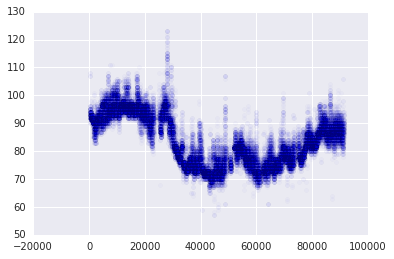

In [10]:
plt.scatter(vital_offset, vital_val, alpha = 0.02)